In [1]:
import xarray as xr
from metpy.units import units
import pint_xarray
import matplotlib.pyplot as plt

from sublimpy import utils
import pytz

In [2]:
start_date = '20221130'
end_date = '20230509'

In [3]:
inputs_fn = '~/Development/data/sublimationofsnow/pysumma_inputs/kettleponds_sos_pysumma_inputs_30min.cdf'
outputs_fn = '~/Development/data/sublimationofsnow/pysumma_outputs/tilden_output_30min_timestep.nc'
outputs = xr.open_dataset(outputs_fn).sel(time=slice(start_date, end_date))
inputs = xr.open_dataset(inputs_fn).sel(time=slice(start_date, end_date))

outputs = utils.modify_xarray_timezone(
    outputs,
    pytz.UTC,
    pytz.timezone("US/Mountain")
)
inputs = utils.modify_xarray_timezone(
    inputs,
    pytz.UTC,
    pytz.timezone("US/Mountain")
)
inputs = inputs.resample(time='60Min').mean()

# Examine Sublimation, seasonal

## Convert latent heat flux measurements to units of mm SWE

In [4]:
latent_heat_of_vaporization = - 2838 * units("J/g")
seconds_per_60min = 60*60
from metpy.constants import density_water

# convert latent heat flux measurements that come in units of w/m^2 to mm SWE
def convert_latheat_w_per_m2_measurement_to_mmSWE(variable):
    return (
        variable * units("W/m^2") / latent_heat_of_vaporization
    ).pint.to("g/(m^2 * s)").pint.magnitude * seconds_per_60min / density_water.magnitude
# convert latent heat flux measurements that come in units of kg/m^2/s to mm SWE
def convert_latheat_kg_per_m2s_measurement_to_mmSWE(variable):
    return (
        variable * units("kg/m^2/s")
    ).pint.to("g/m^2/s").pint.magnitude * seconds_per_60min / density_water.magnitude

outputs['scalarLatHeatTotal_mmSWE'] = (('time', 'hru'), convert_latheat_w_per_m2_measurement_to_mmSWE(outputs['scalarLatHeatTotal']))
outputs['scalarLatHeatCanopyEvap_mmSWE'] = (('time', 'hru'), convert_latheat_w_per_m2_measurement_to_mmSWE(outputs['scalarLatHeatCanopyEvap']))
outputs['scalarLatHeatCanopyTrans_mmSWE'] = (('time', 'hru'), convert_latheat_w_per_m2_measurement_to_mmSWE(outputs['scalarLatHeatCanopyTrans']))
outputs['scalarLatHeatGround_mmSWE'] = (('time', 'hru'), convert_latheat_w_per_m2_measurement_to_mmSWE(outputs['scalarLatHeatGround']))
outputs['scalarCanopySublimation_mmSWE'] = (('time', 'hru'), convert_latheat_kg_per_m2s_measurement_to_mmSWE(outputs['scalarCanopySublimation']))
outputs['scalarSnowSublimation_mmSWE'] = (('time', 'hru'), convert_latheat_kg_per_m2s_measurement_to_mmSWE(outputs['scalarSnowSublimation']))
outputs['scalarCanopyTranspiration_mmSWE'] = (('time', 'hru'), convert_latheat_kg_per_m2s_measurement_to_mmSWE(outputs['scalarCanopyTranspiration']))
outputs['scalarCanopyEvaporation_mmSWE'] = (('time', 'hru'), convert_latheat_kg_per_m2s_measurement_to_mmSWE(outputs['scalarCanopyEvaporation']))
outputs['scalarGroundEvaporation_mmSWE'] = (('time', 'hru'), convert_latheat_kg_per_m2s_measurement_to_mmSWE(outputs['scalarGroundEvaporation']))

In [5]:
inputs['w_h2o__3m_c_mmSWE'] = ('time', convert_latheat_kg_per_m2s_measurement_to_mmSWE(
    inputs['w_h2o__3m_c']/1000
))

## Plot canopy + surface and surface sublimation

In [6]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6, 4)

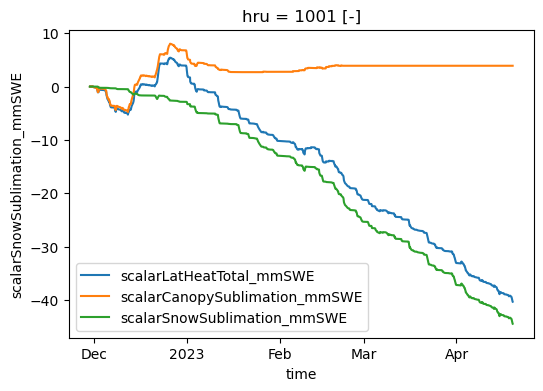

In [7]:
# ( - outputs['scalarCanopySublimation_mmSWE'] - outputs['scalarSnowSublimation_mmSWE']).cumsum().plot.scatter(
#     label =        'scalarCanopySublimation_mmSWE\n+ scalarSnowSublimation_mmSWE',
#     s = 1,
#     color='k',
#     zorder=10
# )
outputs['scalarLatHeatTotal_mmSWE'].cumsum().plot(
    label =           'scalarLatHeatTotal_mmSWE'
)
( - outputs['scalarCanopySublimation_mmSWE']).cumsum().plot(
    label =      'scalarCanopySublimation_mmSWE'
)
( - outputs['scalarSnowSublimation_mmSWE']).cumsum().plot(
    label =        'scalarSnowSublimation_mmSWE'
)

plt.legend()
# plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

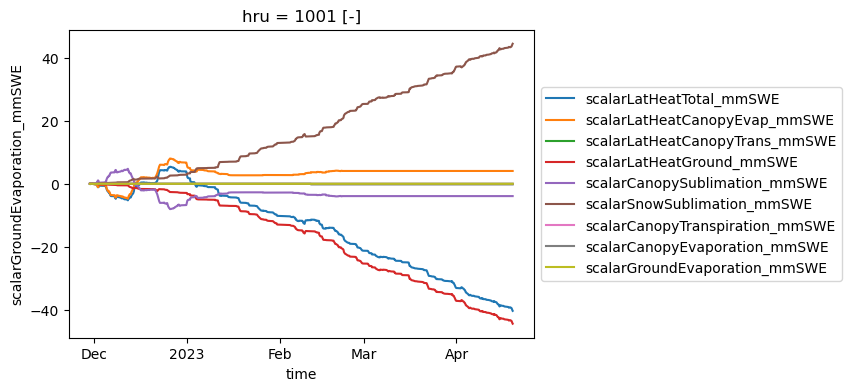

In [8]:
outputs['scalarLatHeatTotal_mmSWE'].cumsum().plot(label =           'scalarLatHeatTotal_mmSWE')
outputs['scalarLatHeatCanopyEvap_mmSWE'].cumsum().plot(label =      'scalarLatHeatCanopyEvap_mmSWE')
outputs['scalarLatHeatCanopyTrans_mmSWE'].cumsum().plot(label =     'scalarLatHeatCanopyTrans_mmSWE')
outputs['scalarLatHeatGround_mmSWE'].cumsum().plot(label =          'scalarLatHeatGround_mmSWE')
outputs['scalarCanopySublimation_mmSWE'].cumsum().plot(label =      'scalarCanopySublimation_mmSWE')
outputs['scalarSnowSublimation_mmSWE'].cumsum().plot(label =        'scalarSnowSublimation_mmSWE')
outputs['scalarCanopyTranspiration_mmSWE'].cumsum().plot(label =    'scalarCanopyTranspiration_mmSWE')
outputs['scalarCanopyEvaporation_mmSWE'].cumsum().plot(label =      'scalarCanopyEvaporation_mmSWE')
outputs['scalarGroundEvaporation_mmSWE'].cumsum().plot(label =      'scalarGroundEvaporation_mmSWE')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

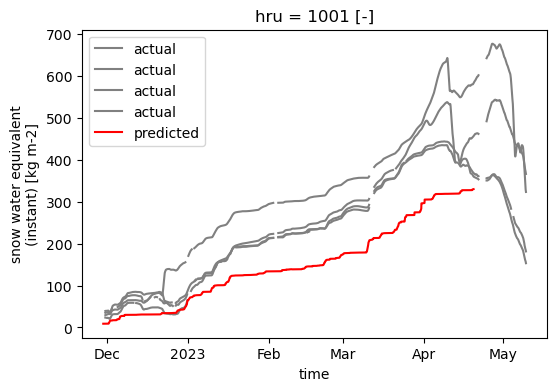

In [9]:
inputs['SWE_p1_c'].rolling(time=20).mean().plot(label="actual", color="grey")
inputs['SWE_p2_c'].rolling(time=20).mean().plot(label="actual", color="grey")
inputs['SWE_p3_c'].rolling(time=20).mean().plot(label="actual", color="grey")
inputs['SWE_p4_c'].rolling(time=20).mean().plot(label="actual", color="grey")
outputs['scalarSWE'].plot(label="predicted", color='red')
plt.legend()
plt.show()

# Look at air and surface temperatures

In [10]:
start_date_casestudy = '20221217'
end_date_casestudy = '20221225'

# start_date_casestudy = '20230205'
# end_date_casestudy = '20230212'

In [11]:
from sublimpy import extrautils


night_df = extrautils.get_nightime_df(
    'US/Mountain', 
    38.944891, 
    -106.975796,
    sorted(list(set(
        inputs['T_3m_c'].sel(time = slice(start_date_casestudy, end_date_casestudy)).time.dt.date.values
    )))
)

ModuleNotFoundError: No module named 'turbpy'

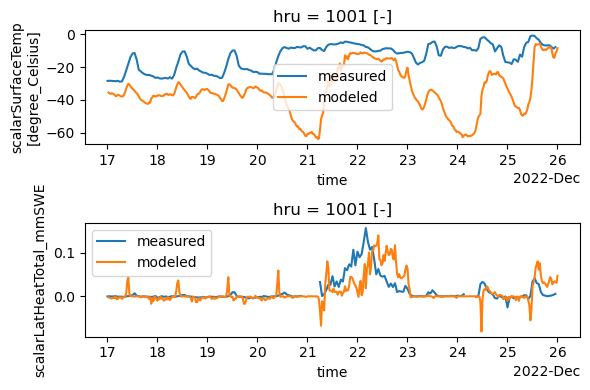

In [12]:
fig, axes = plt.subplots(2, 1)

inputs['Tsurf_c'].sel(time=slice(start_date_casestudy, end_date_casestudy)).plot(label='measured', ax=axes[0])
(
    outputs['scalarSurfaceTemp']*units("kelvin")
).pint.to("celsius").sel(time=slice(start_date_casestudy, end_date_casestudy)).plot(label='modeled', ax=axes[0])
axes[0].legend()
# for i,row in night_df.iterrows():
    # axes[0].axvspan(row['sunset'], row['sunrise'], color='lightgrey', alpha=0.5)


inputs['w_h2o__3m_c_mmSWE'].sel(time=slice(start_date_casestudy, end_date_casestudy)).plot(label='measured', ax=axes[1])
(
    outputs['scalarLatHeatTotal_mmSWE']
).sel(time=slice(start_date_casestudy, end_date_casestudy)).plot(label='modeled', ax=axes[1])
axes[1].legend()
# for i,row in night_df.iterrows():
    # axes[1].axvspan(row['sunset'], row['sunrise'], color='lightgrey', alpha=0.5)
plt.tight_layout()
plt.show()